<a href="https://colab.research.google.com/github/Bionerdess/NMA2021/blob/ALedits/NMA2021_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy 2021
### Collaborative Project analyzing data by Steinmetz et. al., 2019
By Anna-Lena Schlenner, Shira Lupkin, Katrina Lee Bartas and Joaquin Herrero

In [26]:
#@title Necesssary imports
from scipy import stats, io
import numpy as np
import os, requests
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style(style='whitegrid',rc={'grid.linewidth': 2})

from matplotlib import rcParams 
import pandas as pd
import pickle

In [2]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [3]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [30]:
#title Retreive relevant data

vis_ses=[]

for s in range(len(alldat)):
  dat=alldat[s]
  if 'VISp' in dat['brain_area']:
    vis_ses.append(s)

alldat = alldat[vis_ses]

variables = [['spks'],['brain_area'],['reaction_time'],['response_time'], 
             ['response'],['contrast_left'],['contrast_right'],['feedback_type'],['bin_size']]
dd = np.array([])

for s in range(alldat.shape[0]):

  newdat = dict()
  dat = alldat[s]

  for key in dat:
    if  np.isin(key,variables):
      newdat[key] = dat[key]
  dd = np.hstack((dd,newdat))

print('Number of sessions with VISp recordings: {}'.format(dd.shape[0]))

Number of sessions with VISp recordings: 12


In [11]:
#@title Extract VISp FR for each contrast level
visDat00 = np.empty((dd.shape[0],250))
visDat25 = np.empty((dd.shape[0],250))
visDat05 = np.empty((dd.shape[0],250))
visDat1 = np.empty((dd.shape[0],250))

for s in range(dd.shape[0]):
  roi = dd[s]['brain_area']
  spks = dd[s]['spks'][roi=='VISp']
  contrast_right = dd[s]['contrast_right']
  visDat00[s] = spks[:,contrast_right==0.0,:].mean(axis=(0,1))
  visDat25[s] = spks[:,contrast_right==0.25,:].mean(axis=(0,1))
  visDat05[s] = spks[:,contrast_right==0.5,:].mean(axis=(0,1))
  visDat1[s] = spks[:,contrast_right==1.0,:].mean(axis=(0,1))


(12, 250)
(12, 250)
(12, 250)
(12, 250)
(12, 250)
(12, 250)
(12, 250)
(12, 250)
(12, 250)
(12, 250)
(12, 250)
(12, 250)


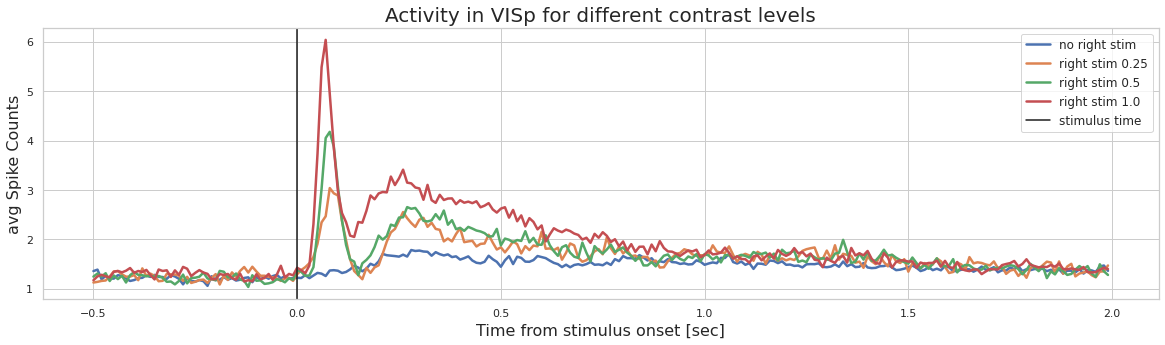

In [28]:
#@title Plot VISp across contrast levels

bins = dd[0]['bin_size']
x = np.arange(-.5,2.0,bins)

plt.figure(figsize=(20,5))
plt.plot(x,1/bins * visDat00.mean(axis=0),linewidth=2.5)
plt.plot(x,1/bins * visDat25.mean(axis=0),linewidth=2.5)
plt.plot(x,1/bins * visDat05.mean(axis=0),linewidth=2.5)
plt.plot(x,1/bins * visDat1.mean(axis=0),linewidth=2.5)
plt.axvline(0,color='k')
plt.legend(['no right stim','right stim 0.25','right stim 0.5','right stim 1.0', 'stimulus time'], fontsize=12)
plt.xlabel('Time from stimulus onset [sec]',size=16)
plt.ylabel('avg Spike Counts',size=16)
plt.title('Activity in VISp for different contrast levels',size=20)
plt.show()